In [1]:
# @title Data Reading and processing
import pandas as pd
import os
from pandas import ExcelFile
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.multitest import multipletests
import warnings
from scipy.spatial.distance import pdist, squareform
from scipy.stats import entropy
from scipy.signal import savgol_filter
from scipy.spatial.distance import euclidean
#from skbio.stats.composition import clr
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from tqdm import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, make_scorer, accuracy_score, f1_score



gene_count_path = '/content/drive/MyDrive/MITResearch/sparsecca/target.gene.count.matrix.csv'
metaphlan_path = '/content/drive/MyDrive/MITResearch/sparsecca/UMCGPilotdata_metaphlan.xlsx'

# Load gene count matrix
gene_count_df = pd.read_csv(gene_count_path)
metaphlan_df = pd.read_excel(metaphlan_path)
print(gene_count_df.shape)
print(metaphlan_df.shape)

(543, 213)
(228, 597)


In [2]:
# @title

# ---- Data Transformation Section ----
# Transpose gene count matrix to align with metaphlan_df data format
gene_count_df = gene_count_df.T

# Set the first row as column names and convert the matrix to a dataframe
new_col_names = gene_count_df.iloc[0]  # First row for column names
gene_count_df = gene_count_df[1:]  # Remove the first row
gene_count_df.columns = new_col_names  # Set new column names
gene_count_df.reset_index(drop=False,inplace=True)
gene_count_df.rename(columns={'index': 'PatientID_Weeknr'}, inplace=True)

# Align metaphlan_df PatientID_Weeknr format with gene_count_df
metaphlan_df['PatientID_Weeknr'] = metaphlan_df['PatientID_Weeknr'].str.replace("Weekly_Feces_", "")
metaphlan_df['PatientID_Weeknr'] = metaphlan_df['PatientID_Weeknr'].str.replace("_Week_", "__Week_")
metaphlan_df['PatientID_Weeknr'] = metaphlan_df['PatientID_Weeknr'].str.replace("_(\\d)$", r"_0\1", regex=True)

pattern = r'^TR_\d+__Week_\d{2}$'

# Identify and print rows with incorrect formats
invalid_df = gene_count_df[~gene_count_df['PatientID_Weeknr'].str.match(pattern)]
if not invalid_df.empty:
    print("Rows removed (incorrect format):")
    print(invalid_df['PatientID_Weeknr'])
else:
    print("No rows removed.")

gene_count_df = gene_count_df[gene_count_df['PatientID_Weeknr'].str.match(pattern)]

Rows removed (incorrect format):
15    TR_2101__Week_17_2
18    TR_2101__Week_19_2
Name: PatientID_Weeknr, dtype: object


In [3]:
# @title split and insert function
def split_and_insert(df, column_name, split_str):
    df[column_name] = df[column_name].astype(str)
    patient_id, week = df[column_name].str.split(split_str, expand=True)[0], df[column_name].str.extract('(\d+)$')[0].astype(int)
    df.insert(0, 'week', week)
    df.insert(0, 'patient_id', patient_id)
    df.drop(column_name, axis=1, inplace=True)
    return df

In [4]:
# @title flag_first_flare_weeks function

def flag_first_flare_weeks(df):
    # Identify the rows where flare starts
    df['is_flare'] = (df['Flare_status'] == 'During_flare') | (df['Flare_status'] == 'During_flare_2')

    # Sort by patient and week to ensure the chronological order
    df.sort_values(by=['patient_id', 'week'], inplace=True)

    # Mark each flare start for each patient
    df['Flare_start'] = (df['is_flare']) & (df['is_flare'] != df['is_flare'].shift(1))

    # Convert boolean to integer (1 for True, 0 for False)
    df['Flare_start'] = df['Flare_start'].astype(int)

    # Drop helper columns if they are no longer needed
    df.drop('is_flare', axis=1, inplace=True)

    return df

In [5]:
# @title normalize_to_housekeeping_genes function
def normalize_to_housekeeping_genes(df, housekeeping_genes, exclude_columns):
    # Convert data in DataFrame to numeric types, except for excluded columns
    for column in df.columns:
        if column not in exclude_columns:
            df[column] = pd.to_numeric(df[column], errors='coerce')

    # Find columns that start with any of the housekeeping gene symbols and are not in the excluded list
    hk_gene_cols = [col for col in df.columns
                    if any(col.startswith(hk + '_') for hk in housekeeping_genes) and col not in exclude_columns]

    # Selecting housekeeping genes data
    hk_genes_data = df[hk_gene_cols]

    # Calculate the geometric mean of the housekeeping genes for each sample
    # Adding a small value (e.g., 1e-9) to avoid taking log(0)
    geometric_mean_hk = np.exp(np.log(hk_genes_data + 1e-9).mean(axis=1))

    # Normalize the entire gene count matrix by the geometric mean of the housekeeping genes
    # Apply normalization only to numeric columns
    for column in df.columns:
        if column not in exclude_columns:
            df[column] = df[column].div(geometric_mean_hk, axis=0)

    return df

In [6]:
# @title assign_rbf

def assign_rbf(df, samples_before_flare=6):
    # Initial setup
    df = df.sort_values(by=['patient_id', 'week'])
    df['RBF'] = 0  # Initialize the RBF column

    # Identify patients and the weeks where flares start
    flare_starts = df[df['Flare_start'] == 1].groupby('patient_id')['week'].min()

    for patient, flare_week in flare_starts.items():
        # Get all weeks for the current patient
        patient_weeks = df.loc[df['patient_id'] == patient, 'week']

        # Find the indexes for weeks before the flare start
        weeks_before_flare = patient_weeks[patient_weeks < flare_week].nlargest(samples_before_flare)

        # Set RBF to 1 for these weeks
        df.loc[(df['patient_id'] == patient) & (df['week'].isin(weeks_before_flare)), 'RBF'] = 1

    return df

In [7]:
# @title Split 'PatientID_Weeknr' in patient id and week
metaphlan_df = split_and_insert(metaphlan_df, 'PatientID_Weeknr', '__')
gene_count_df = split_and_insert(gene_count_df, 'PatientID_Weeknr', '__')
metaphlan_df = metaphlan_df.drop(['SampleName', 'Weeknumber', 'Exacerbation_judgement_treatingphysician'], axis=1)

In [8]:
# @title plot_species_abundance_over_time_2 function
def plot_species_abundance_over_time_2(df, cols_to_plot, title, type_):
    """
    Plots the abundance over time for the specified species for all patients in the dataframe,
    with separate plots for patients with and without a flare start, all in a single figure with subplots.

    Args:
    df (pd.DataFrame): DataFrame containing microbial abundance data.
    cols_to_plot (list): List of species names to plot.
    title (str): Title for the plots and y-axis label.
    type_ (str): Label for the plot legend.
    """
    if not cols_to_plot:
        raise ValueError("cols_to_plot must be provided when selection_mode is 'user'")

    num_species = len(cols_to_plot)
    cols = 2  # Number of columns for subplots (one for with flare, one for without)
    rows = num_species  # Each species will occupy one row with two subplots

    fig, axs = plt.subplots(rows, cols, figsize=(20, 5 * rows))  # Adjust figsize as needed

    # If only one species, axs might not be a 2D array, ensure it is
    if num_species == 1:
        axs = [axs]

    for i, species in enumerate(cols_to_plot):
        # Plot for patients with flare
        ax = axs[i][0]
        patients_with_flare = df[df['Flare_status'] == "During_flare"]['patient_id'].unique()
        for patient in patients_with_flare:
            patient_data = df[df['patient_id'] == patient].copy()
            patient_data.sort_values(by='week', inplace=True)  # Ensure data is sorted by week

            if species in patient_data.columns:
                sns.lineplot(data=patient_data, x='week', y=species, ax=ax, label=f'Patient {patient}')

        # Annotate flare start changes
        flare_changes = df[df["Flare_start"] == 1][['week', 'Flare_start']].drop_duplicates()
        for _, (week, status) in flare_changes.iterrows():
            ax.axvline(x=week, color='grey', linestyle='--')
            ax.text(week, ax.get_ylim()[1], 'Flare_start', verticalalignment='top', fontsize=8)

        ax.set_title(f'{title} ({species}) Over Time for Patients with Flare')
        ax.set_xlabel('Week')
        ax.set_ylabel(title)
        ax.legend(title=type_, bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.set_xticks(df['week'].unique())
        ax.set_xticklabels(df['week'].unique(), rotation=45)

        # Plot for patients without flare
        ax = axs[i][1]
        patients_without_flare = df[~df['patient_id'].isin(patients_with_flare)]['patient_id'].unique()
        for patient in patients_without_flare:
            patient_data = df[df['patient_id'] == patient].copy()
            patient_data.sort_values(by='week', inplace=True)  # Ensure data is sorted by week

            if species in patient_data.columns:
                sns.lineplot(data=patient_data, x='week', y=species, ax=ax, label=f'Patient {patient}')

        ax.set_title(f'{title} ({species}) Over Time for Patients without Flare')
        ax.set_xlabel('Week')
        ax.set_ylabel(title)
        ax.legend(title=type_, bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.set_xticks(df['week'].unique())
        ax.set_xticklabels(df['week'].unique(), rotation=45)

    plt.tight_layout()
    plt.show()


In [9]:
print(gene_count_df.shape)
print(metaphlan_df.shape)

(210, 545)
(228, 595)


In [10]:
# @title merge metaphlan with gene_count to get the Flare_satus
gene_count_df = pd.merge(gene_count_df, metaphlan_df[['patient_id', 'week', 'Flare_status']], on=['patient_id', 'week'], how='left')
cols = ['Flare_status'] + [col for col in gene_count_df.columns if col != 'Flare_status']
gene_count_df = gene_count_df[cols]


gene_count_df.sort_values(by=['patient_id', 'week'], inplace=True)

# Step 3: Fill missing 'Flare_status' values using forward fill
gene_count_df['Flare_status'] = gene_count_df['Flare_status'].fillna(method='ffill')


In [11]:
print(gene_count_df.shape)
print(metaphlan_df.shape)

(210, 546)
(228, 595)


In [12]:
# @title Adding a Flare_start column
metaphlan_df = flag_first_flare_weeks(metaphlan_df)
gene_count_df = flag_first_flare_weeks(gene_count_df)

In [13]:
# @title normalize to housekeeping genes
house_keeping_genes = ["ACTB", "ATP5F1", "B2M", "GAPDH", "GUSB",
                       "HPRT", "PGK1", "PPIA", "RPS18", "TBP",
                       "TFRC", "YWHAZ"]

# Columns to exclude from normalization
exclude_columns = ['Flare_status', 'patient_id', 'week', 'Flare_start']

# Normalizing the DataFrame
normalized_df = normalize_to_housekeeping_genes(gene_count_df, house_keeping_genes, exclude_columns)

In [15]:
gene_count_df["week"].max()

53

In [16]:
week_stats = gene_count_df.groupby('patient_id')['week'].agg(['min', 'max'])

print(week_stats)

            min  max
patient_id          
TR_2101       1   52
TR_2102       1   53
TR_2103       1   52
TR_2201       1   52
TR_2202       1   50


In [17]:
week_stats = metaphlan_df.groupby('patient_id')['week'].agg(['min', 'max'])
print(week_stats)

            min  max
patient_id          
TR_2101       1   52
TR_2102       1   53
TR_2103       1   52
TR_2201       1   52
TR_2202       1   50


In [18]:
week_stats = df.groupby('Patient_Tracker_ID')['Week_Numeric'].agg(['min', 'max'])

print(week_stats)

                    min   max
Patient_Tracker_ID           
TR_2101             1.0  53.0
TR_2102             0.0  52.0
TR_2103             0.0  52.0
TR_2201             0.0  51.0
TR_2202             0.0  51.0


# Classification for Gene Expression

In [19]:
cols_to_drop = [ 'week', 'Flare_start','Flare_status', 'RBF']

In [20]:
# @title Processing function
def processing(df, cols_to_drop):
  #Assign RBF flags with 6 samples before flare as default or any other number you wish
  df = assign_rbf(df, samples_before_flare=6)


  data = df[(df["Flare_status"] != "Post_flare") &
              (df["Flare_status"] != "During_flare") &
              (df["Flare_status"] != "During_flare_2")]

  original_columns = set(data.columns)
  data = pd.get_dummies(data, columns=['patient_id'], drop_first=True)
  patient_cols = list(set(data.columns) - original_columns)

  print(data["RBF"].value_counts())
  return data, patient_cols

In [21]:
# @title hyperparameter tuning function

def hyperparameter_tuning(data, cols_to_drop, patient_cols):
  # Drop specified columns and separate features and target
  X = data.drop(cols_to_drop + patient_cols, axis=1)
  y = data['RBF']

  # Define the parameter grid
  # param_grid = {
  #     'n_estimators': [100, 200, 300],  # Number of trees in the forest
  #     'max_features': ['auto', 'sqrt'],  # Number of features to consider at every split
  #     'max_depth': [None, 10, 20, 30],   # Maximum number of levels in tree
  #     'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split a node
  #     'min_samples_leaf': [1, 2, 4]      # Minimum number of samples required at each leaf node
  # }

  param_grid = {
      'n_estimators': [25, 50],  # Number of trees in the forest
      'max_features': ['auto', 'sqrt'],  # Number of features to consider at every split
      'max_depth': [None, 10, 30],   # Maximum number of levels in tree
      'min_samples_split': [2,10, 15],   # Minimum number of samples required to split a node
      'min_samples_leaf': [1, 3]      # Minimum number of samples required at each leaf node
  }

  # Initialize the Random Forest classifier
  clf = RandomForestClassifier(random_state=421)

  # Define scoring strategy
  scoring = 'recall'

  cv = StratifiedKFold(n_splits=10)
  grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, scoring=scoring, n_jobs=-1, verbose=5)

  # Fit the grid search to the data
  grid_search.fit(X, y)

  # Print the best parameters and best score
  print("Best parameters:", grid_search.best_params_)
  print("Best cross-validation F1 score: {:.2f}".format(grid_search.best_score_))

  # Use the best estimator to make predictions
  best_clf = grid_search.best_estimator_

  importances = best_clf.feature_importances_
  # Get the index of importances from highest importance to lowest
  sorted_index = np.argsort(importances)[::-1]
  print("Feature ranking:")

  for idx in sorted_index:
    if importances[idx] > 0.01:
      print(f"{X.columns[idx]}: ({importances[idx]})")

  return grid_search

In [22]:
# @title model evaluation
def model_evaluation(data, grid_search, cols_to_drop, patient_cols, data_type='validation', n_splits=10):
    """
    Evaluate the model using either training data or unseen data.

    Parameters:
    data (pd.DataFrame): The dataframe containing the data.
    grid_search: The GridSearchCV object containing the trained model.
    cols_to_drop (list of str): The list of columns to drop.
    patient_cols (list of str): The list of dummy patient_id columns.
    data_type (str): The type of data to evaluate ('training' or 'validation'). Default is 'validation'.
    n_splits (int): Number of splits for cross-validation. Default is 10.

    Returns:
    None
    """
    # Initialize results storage
    confusion_matrices = []
    accuracies = []
    precisions = []

    # Data preparation
    X = data.drop(cols_to_drop + patient_cols, axis=1)
    y = data['RBF']

    # Best model from GridSearchCV
    best_clf = grid_search.best_estimator_

    if data_type == 'validation':
        # Conduct the stratified cross-validation
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

        for train_index, test_index in tqdm(skf.split(X, y), total=n_splits, desc='Cross-validation'):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Fit the model
            best_clf.fit(X_train, y_train)

            # Predict on the test set
            y_pred = best_clf.predict(X_test)

            # Compute confusion matrix and store results
            cm = confusion_matrix(y_test, y_pred)
            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, zero_division=0)  # Avoid division by zero

            confusion_matrices.append(cm)
            accuracies.append(acc)
            precisions.append(prec)

        # Print all results
        for i, (cm, acc, prec) in enumerate(zip(confusion_matrices, accuracies, precisions), 1):
            print(f"Fold {i}:")
            print("Confusion Matrix:")
            print(cm)
            print(f"Accuracy: {acc:.2f}")
            print(f"Precision: {prec:.2f}")
            print("")

        # Optionally calculate and display average scores
        print("Average Accuracy:", np.mean(accuracies))
        print("Average Precision:", np.mean(precisions))

    elif data_type == 'training':
        # Fit the model
        best_clf.fit(X, y)

        # Predict on the training set
        y_pred = best_clf.predict(X)

        # Compute confusion matrix and store results
        cm = confusion_matrix(y, y_pred)
        acc = accuracy_score(y, y_pred)
        prec = precision_score(y, y_pred, zero_division=0)  # Avoid division by zero

        confusion_matrices.append(cm)
        accuracies.append(acc)
        precisions.append(prec)

        # Print all results
        print("Training Set Results:")
        print("Confusion Matrix:")
        print(cm)
        print(f"Accuracy: {acc:.2f}")
        print(f"Precision: {prec:.2f}")
        print("")

    else:
        raise ValueError("data_type must be 'training' or 'validation'")

In [23]:
# @title Gene Expression modeling
gene_count, patient_cols = processing(gene_count_df, cols_to_drop)
grid_search = hyperparameter_tuning(gene_count, cols_to_drop, patient_cols)

RBF
0    131
1     18
Name: count, dtype: int64
Fitting 10 folds for each of 72 candidates, totalling 720 fits
Best parameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 25}
Best cross-validation F1 score: 0.10
Feature ranking:
CD14_ENSG00000170458_ENST00000512545: (0.02579075287767042)
CX3CL1_ENSG00000006210_ENST00000006053: (0.024989113323598214)
ERBIN_ENSG00000112851_ENST00000511297: (0.024576922656626508)
SLC2A14_ENSG00000173262_ENST00000340749: (0.021700709179982288)
CCR3_ENSG00000183625_ENST00000357422: (0.020960016051739715)
CSF3R_ENSG00000119535_ENST00000373106: (0.02030380536187329)
IL18_ENSG00000150782_ENST00000280357: (0.020200984072214486)
ICAM1_ENSG00000090339_ENST00000264832: (0.01960305733018159)
FFAR3_ENSG00000185897_ENST00000327809: (0.018251789365267387)
LEP_ENSG00000174697_ENST00000308868: (0.015696961890671896)
IL2RA_ENSG00000134460_ENST00000379959: (0.014749109402286235)
CCR5_ENSG00000160791_ENST00000

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [24]:
print("Best parameters:", grid_search.best_params_)
model_evaluation(gene_count, grid_search, cols_to_drop, patient_cols, data_type='training', n_splits=10)
model_evaluation(gene_count, grid_search, cols_to_drop, patient_cols, data_type='validation', n_splits=10)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best parameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 25}
Training Set Results:
Confusion Matrix:
[[131   0]
 [  0  18]]
Accuracy: 1.00
Precision: 1.00



Cross-validation:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
Cross-validation:  20%|██        | 2/10 [00:00<00:00, 12.70it/s]/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

Fold 1:
Confusion Matrix:
[[14  0]
 [ 1  0]]
Accuracy: 0.93
Precision: 0.00

Fold 2:
Confusion Matrix:
[[13  0]
 [ 2  0]]
Accuracy: 0.87
Precision: 0.00

Fold 3:
Confusion Matrix:
[[12  1]
 [ 2  0]]
Accuracy: 0.80
Precision: 0.00

Fold 4:
Confusion Matrix:
[[13  0]
 [ 2  0]]
Accuracy: 0.87
Precision: 0.00

Fold 5:
Confusion Matrix:
[[13  0]
 [ 2  0]]
Accuracy: 0.87
Precision: 0.00

Fold 6:
Confusion Matrix:
[[13  0]
 [ 1  1]]
Accuracy: 0.93
Precision: 1.00

Fold 7:
Confusion Matrix:
[[13  0]
 [ 2  0]]
Accuracy: 0.87
Precision: 0.00

Fold 8:
Confusion Matrix:
[[13  0]
 [ 2  0]]
Accuracy: 0.87
Precision: 0.00

Fold 9:
Confusion Matrix:
[[13  0]
 [ 2  0]]
Accuracy: 0.87
Precision: 0.00

Fold 10:
Confusion Matrix:
[[13  0]
 [ 1  0]]
Accuracy: 0.93
Precision: 0.00

Average Accuracy: 0.8795238095238096
Average Precision: 0.1


In [25]:
# @title Microbial abundance modeling
metaphlan, patient_cols  = processing(metaphlan_df, cols_to_drop)
grid_search = hyperparameter_tuning(metaphlan, cols_to_drop, patient_cols)

RBF
0    134
1     18
Name: count, dtype: int64
Fitting 10 folds for each of 72 candidates, totalling 720 fits
Best parameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 25}
Best cross-validation F1 score: 0.15
Feature ranking:
s__GGB4588_SGB6347: (0.09220732909688541)
s__Bacteroides_uniformis: (0.0513670327398534)
s__Bifidobacterium_pullorum: (0.042032363757077223)
s__GGB3640_SGB4937: (0.035620275885077234)
s__Alistipes_putredinis: (0.034442002069957)
s__GGB9494_SGB14891: (0.03099120227403871)
s__Phocaeicola_dorei: (0.029855794818210515)
s__Bifidobacterium_catenulatum: (0.028874417919421854)
s__Blautia_sp_MSK_21_1: (0.0279028028701827)
s__Lacticaseibacillus_rhamnosus: (0.024791034042698355)
s__Sellimonas_intestinalis: (0.024678784409389705)
s__Blautia_sp_MSK_20_85: (0.02289137738145759)
s__GGB4554_SGB6285: (0.02155543445916721)
s__Streptococcus_salivarius: (0.021208617221843667)
s__Coprobacter_fastidiosus: (0.0209917807

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [26]:
print("Best parameters:", grid_search.best_params_)

Best parameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 25}


In [27]:
model_evaluation(metaphlan, grid_search, cols_to_drop, patient_cols, data_type='training', n_splits=10)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Training Set Results:
Confusion Matrix:
[[133   1]
 [  4  14]]
Accuracy: 0.97
Precision: 0.93



In [28]:
model_evaluation(metaphlan, grid_search, cols_to_drop, patient_cols, data_type='validation', n_splits=10)

Cross-validation:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
Cross-validation:  10%|█         | 1/10 [00:00<00:01,  7.35it/s]/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
Cross-validation:  20%|██        | 2/10 [00:00<00:01,  7.75it/s]/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has be

Fold 1:
Confusion Matrix:
[[14  0]
 [ 2  0]]
Accuracy: 0.88
Precision: 0.00

Fold 2:
Confusion Matrix:
[[14  0]
 [ 1  1]]
Accuracy: 0.94
Precision: 1.00

Fold 3:
Confusion Matrix:
[[14  0]
 [ 0  1]]
Accuracy: 1.00
Precision: 1.00

Fold 4:
Confusion Matrix:
[[14  0]
 [ 1  0]]
Accuracy: 0.93
Precision: 0.00

Fold 5:
Confusion Matrix:
[[13  0]
 [ 2  0]]
Accuracy: 0.87
Precision: 0.00

Fold 6:
Confusion Matrix:
[[13  0]
 [ 2  0]]
Accuracy: 0.87
Precision: 0.00

Fold 7:
Confusion Matrix:
[[13  0]
 [ 2  0]]
Accuracy: 0.87
Precision: 0.00

Fold 8:
Confusion Matrix:
[[13  0]
 [ 2  0]]
Accuracy: 0.87
Precision: 0.00

Fold 9:
Confusion Matrix:
[[13  0]
 [ 2  0]]
Accuracy: 0.87
Precision: 0.00

Fold 10:
Confusion Matrix:
[[12  1]
 [ 0  2]]
Accuracy: 0.93
Precision: 0.67

Average Accuracy: 0.9012500000000001
Average Precision: 0.26666666666666666


don't use during flare and post flare samples
add patient id as a feature
ajouter les metadata dans le modele





In [29]:
# @title random forest based on first differences

def calculate_first_differences(df):
    """
    Calculates the first differences for each gene and species column, considering missing weeks and dummy patient_id columns.

    Parameters:
    df (pd.DataFrame): The dataframe containing dummy 'patient_id' columns, 'week', 'Flare_status', 'RBF', and gene/species columns.

    Returns:
    pd.DataFrame: A new dataframe with the first differences and a week column.
    """
    # Identify patient_id columns
    patient_id_columns = [col for col in df.columns if col.startswith('patient_id_')]

    # Identify gene/species columns
    exclude_columns = patient_id_columns + ['week', 'Flare_status', 'RBF']
    gene_species_columns = df.columns.difference(exclude_columns)

    # Sort the dataframe by patient_id columns and week
    df = df.sort_values(by=patient_id_columns + ['week'])

    # Group by patient_id columns and calculate first differences
    df_diff = df.groupby(patient_id_columns).apply(lambda group: group[gene_species_columns].diff()).reset_index(drop=True)
    df.reset_index(drop=True, inplace=True)

    # Correct the week column in the first differences dataset
    df_diff['week'] = df['week']

    # Add patient_id columns back to the first differences dataset
    for col in patient_id_columns:
        df_diff[col] = df[col]

    # Add 'Flare_status' and 'RBF' columns back to the first differences dataset
    df_diff['Flare_status'] = df['Flare_status']
    df_diff['RBF'] = df['RBF']

    # Remove the first week for each patient as we cannot compute the difference for the first week
    df_diff.dropna(inplace=True, subset=gene_species_columns)

    # Reorder columns to match the original structure
    df_diff = df_diff[patient_id_columns + ['week'] + gene_species_columns.tolist() + ['Flare_status', 'RBF']]

    return df_diff

In [30]:
fd_metaphlan_df = calculate_first_differences(metaphlan)

grid_search = hyperparameter_tuning(fd_metaphlan_df, cols_to_drop, patient_cols)

print("Best parameters:", grid_search.best_params_)
model_evaluation(fd_metaphlan_df, grid_search, cols_to_drop, patient_cols, data_type='training', n_splits=10)
model_evaluation(fd_metaphlan_df, grid_search, cols_to_drop, patient_cols, data_type='validation', n_splits=10)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best parameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 25}
Best cross-validation F1 score: 0.00
Feature ranking:
s__Bacteroides_uniformis: (0.04753284673150539)
s__Coprobacter_fastidiosus: (0.04429137707152232)
s__Pediococcus_pentosaceus: (0.042997042122177566)
s__Alistipes_putredinis: (0.04045508930370693)
s__Actinomyces_naeslundii: (0.02535875624557994)
s__Murimonas_intestini: (0.02322446834435843)
s__GGB4588_SGB6347: (0.021488287845364624)
s__Bifidobacterium_pseudocatenulatum: (0.018893603119660218)
s__Clostridia_unclassified_SGB14844: (0.018811318690276496)
s__Faecalibacterium_SGB15346: (0.016629724567992107)
s__Candidatus_Heritagella_gallinarum: (0.0165675169900522)
s__Lachnospiraceae_bacterium_WCA3_601_WT_6H: (0.01637499999999999)
s__Adlercreutzia_equolifaciens: (0.015940976224015038)
s__Clostridium_SGB6179: (0.015116790549460897)
s__Clostridiales_bacterium_KLE1615: (0.014745794985718836)
s__Ruminococcus_sp_JE7A

Cross-validation:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
Cross-validation:  20%|██        | 2/10 [00:00<00:00, 13.92it/s]/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

Fold 1:
Confusion Matrix:
[[13  0]
 [ 2  0]]
Accuracy: 0.87
Precision: 0.00

Fold 2:
Confusion Matrix:
[[13  0]
 [ 2  0]]
Accuracy: 0.87
Precision: 0.00

Fold 3:
Confusion Matrix:
[[13  0]
 [ 2  0]]
Accuracy: 0.87
Precision: 0.00

Fold 4:
Confusion Matrix:
[[13  0]
 [ 2  0]]
Accuracy: 0.87
Precision: 0.00

Fold 5:
Confusion Matrix:
[[13  0]
 [ 2  0]]
Accuracy: 0.87
Precision: 0.00

Fold 6:
Confusion Matrix:
[[13  0]
 [ 2  0]]
Accuracy: 0.87
Precision: 0.00

Fold 7:
Confusion Matrix:
[[13  0]
 [ 1  1]]
Accuracy: 0.93
Precision: 1.00

Fold 8:
Confusion Matrix:
[[13  0]
 [ 1  0]]
Accuracy: 0.93
Precision: 0.00

Fold 9:
Confusion Matrix:
[[13  0]
 [ 1  0]]
Accuracy: 0.93
Precision: 0.00

Fold 10:
Confusion Matrix:
[[12  0]
 [ 2  0]]
Accuracy: 0.86
Precision: 0.00

Average Accuracy: 0.8847619047619049
Average Precision: 0.1


In [31]:
fd_gene_count_df = calculate_first_differences(gene_count)

grid_search = hyperparameter_tuning(fd_gene_count_df, cols_to_drop, patient_cols)

print("Best parameters:", grid_search.best_params_)
model_evaluation(fd_gene_count_df, grid_search, cols_to_drop, patient_cols, data_type='training', n_splits=10)
model_evaluation(fd_gene_count_df, grid_search, cols_to_drop, patient_cols, data_type='validation', n_splits=10)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best parameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 25}
Best cross-validation F1 score: 0.05
Feature ranking:
CBR3-AS1_ENSG00000236830_ENST00000432988: (0.04441306731755219)
SLC2A14_ENSG00000173262_ENST00000340749: (0.03488433092072314)
NLRP12_ENSG00000142405_ENST00000324134: (0.030226500572649244)
AKT1_ENSG00000142208_ENST00000554581: (0.029884395701549583)
TNFRSF13C_ENSG00000159958_ENST00000291232: (0.021094345206206344)
ITGAL_ENSG00000005844_ENST00000356798: (0.017470467098181362)
IL19_ENSG00000142224_ENST00000270218: (0.016773967839827052)
LTB_ENSG00000227507_ENST00000429299: (0.01669408393308126)
FFAR3_ENSG00000185897_ENST00000327809: (0.015221570525253138)
CCR3_ENSG00000183625_ENST00000357422: (0.015070296962617942)
EPO_ENSG00000130427_ENST00000252723: (0.014936267271202059)
IGF1_ENSG00000017427_ENST00000337514: (0.014632709243197168)
CX3CL1_ENSG00000006210_ENST00000006053: (0.014376624324414378)
CCL14_ENSG00

Cross-validation:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
Cross-validation:  20%|██        | 2/10 [00:00<00:00, 12.31it/s]/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

Fold 1:
Confusion Matrix:
[[13  0]
 [ 2  0]]
Accuracy: 0.87
Precision: 0.00

Fold 2:
Confusion Matrix:
[[13  0]
 [ 2  0]]
Accuracy: 0.87
Precision: 0.00

Fold 3:
Confusion Matrix:
[[13  0]
 [ 2  0]]
Accuracy: 0.87
Precision: 0.00

Fold 4:
Confusion Matrix:
[[12  1]
 [ 2  0]]
Accuracy: 0.80
Precision: 0.00

Fold 5:
Confusion Matrix:
[[13  0]
 [ 1  0]]
Accuracy: 0.93
Precision: 0.00

Fold 6:
Confusion Matrix:
[[13  0]
 [ 1  0]]
Accuracy: 0.93
Precision: 0.00

Fold 7:
Confusion Matrix:
[[11  1]
 [ 2  0]]
Accuracy: 0.79
Precision: 0.00

Fold 8:
Confusion Matrix:
[[12  0]
 [ 2  0]]
Accuracy: 0.86
Precision: 0.00

Fold 9:
Confusion Matrix:
[[12  0]
 [ 2  0]]
Accuracy: 0.86
Precision: 0.00

Fold 10:
Confusion Matrix:
[[12  0]
 [ 2  0]]
Accuracy: 0.86
Precision: 0.00

Average Accuracy: 0.8614285714285714
Average Precision: 0.0


# Visualizations

In [32]:
# @title align_flare_start_function
def align_flare_start_week(df, flare_column='Flare_start', week_column='week', patient_column='patient_id', target_week=0):
    """
    Adjusts the week numbers for each patient in the dataframe such that the first occurrence
    of Flare_start=1 occurs in the same target week for all patients who have a flare start.

    Args:
    df (pd.DataFrame): DataFrame containing the data.
    flare_column (str): Column name indicating the flare start.
    week_column (str): Column name indicating the week number.
    patient_column (str): Column name indicating the patient ID.
    target_week (int): The week number to which the first flare start should be aligned.

    Returns:
    pd.DataFrame: Modified DataFrame with adjusted week numbers.
    """
    df = df.copy()
    adjusted_dfs = []

    # Add a column indicating if the patient had a flare or not
    df['had_flare'] = df.groupby(patient_column)[flare_column].transform('max')

    for patient in df[patient_column].unique():
        patient_data = df[df[patient_column] == patient].copy()

        if patient_data['had_flare'].iloc[0] == 1:
            flare_week = patient_data[patient_data[flare_column] == 1][week_column].min()
            if pd.notna(flare_week):
                shift = target_week - flare_week
                patient_data[week_column] += shift

        adjusted_dfs.append(patient_data)

    aligned_df = pd.concat(adjusted_dfs)

    # Normalize to ensure there are no negative weeks
    min_week = aligned_df[week_column].min()
    if min_week < 0:
       aligned_df.loc[aligned_df['had_flare'] == 1, week_column] -= min_week

    # Remove the temporary 'had_flare' column before returning
    aligned_df.drop('had_flare', axis=1, inplace=True)

    return aligned_df

In [33]:
gc = align_flare_start_week(gene_count_df, flare_column='Flare_start', week_column='week', patient_column='patient_id', target_week=0)
mt = align_flare_start_week(metaphlan_df, flare_column='Flare_start', week_column='week', patient_column='patient_id', target_week=0)

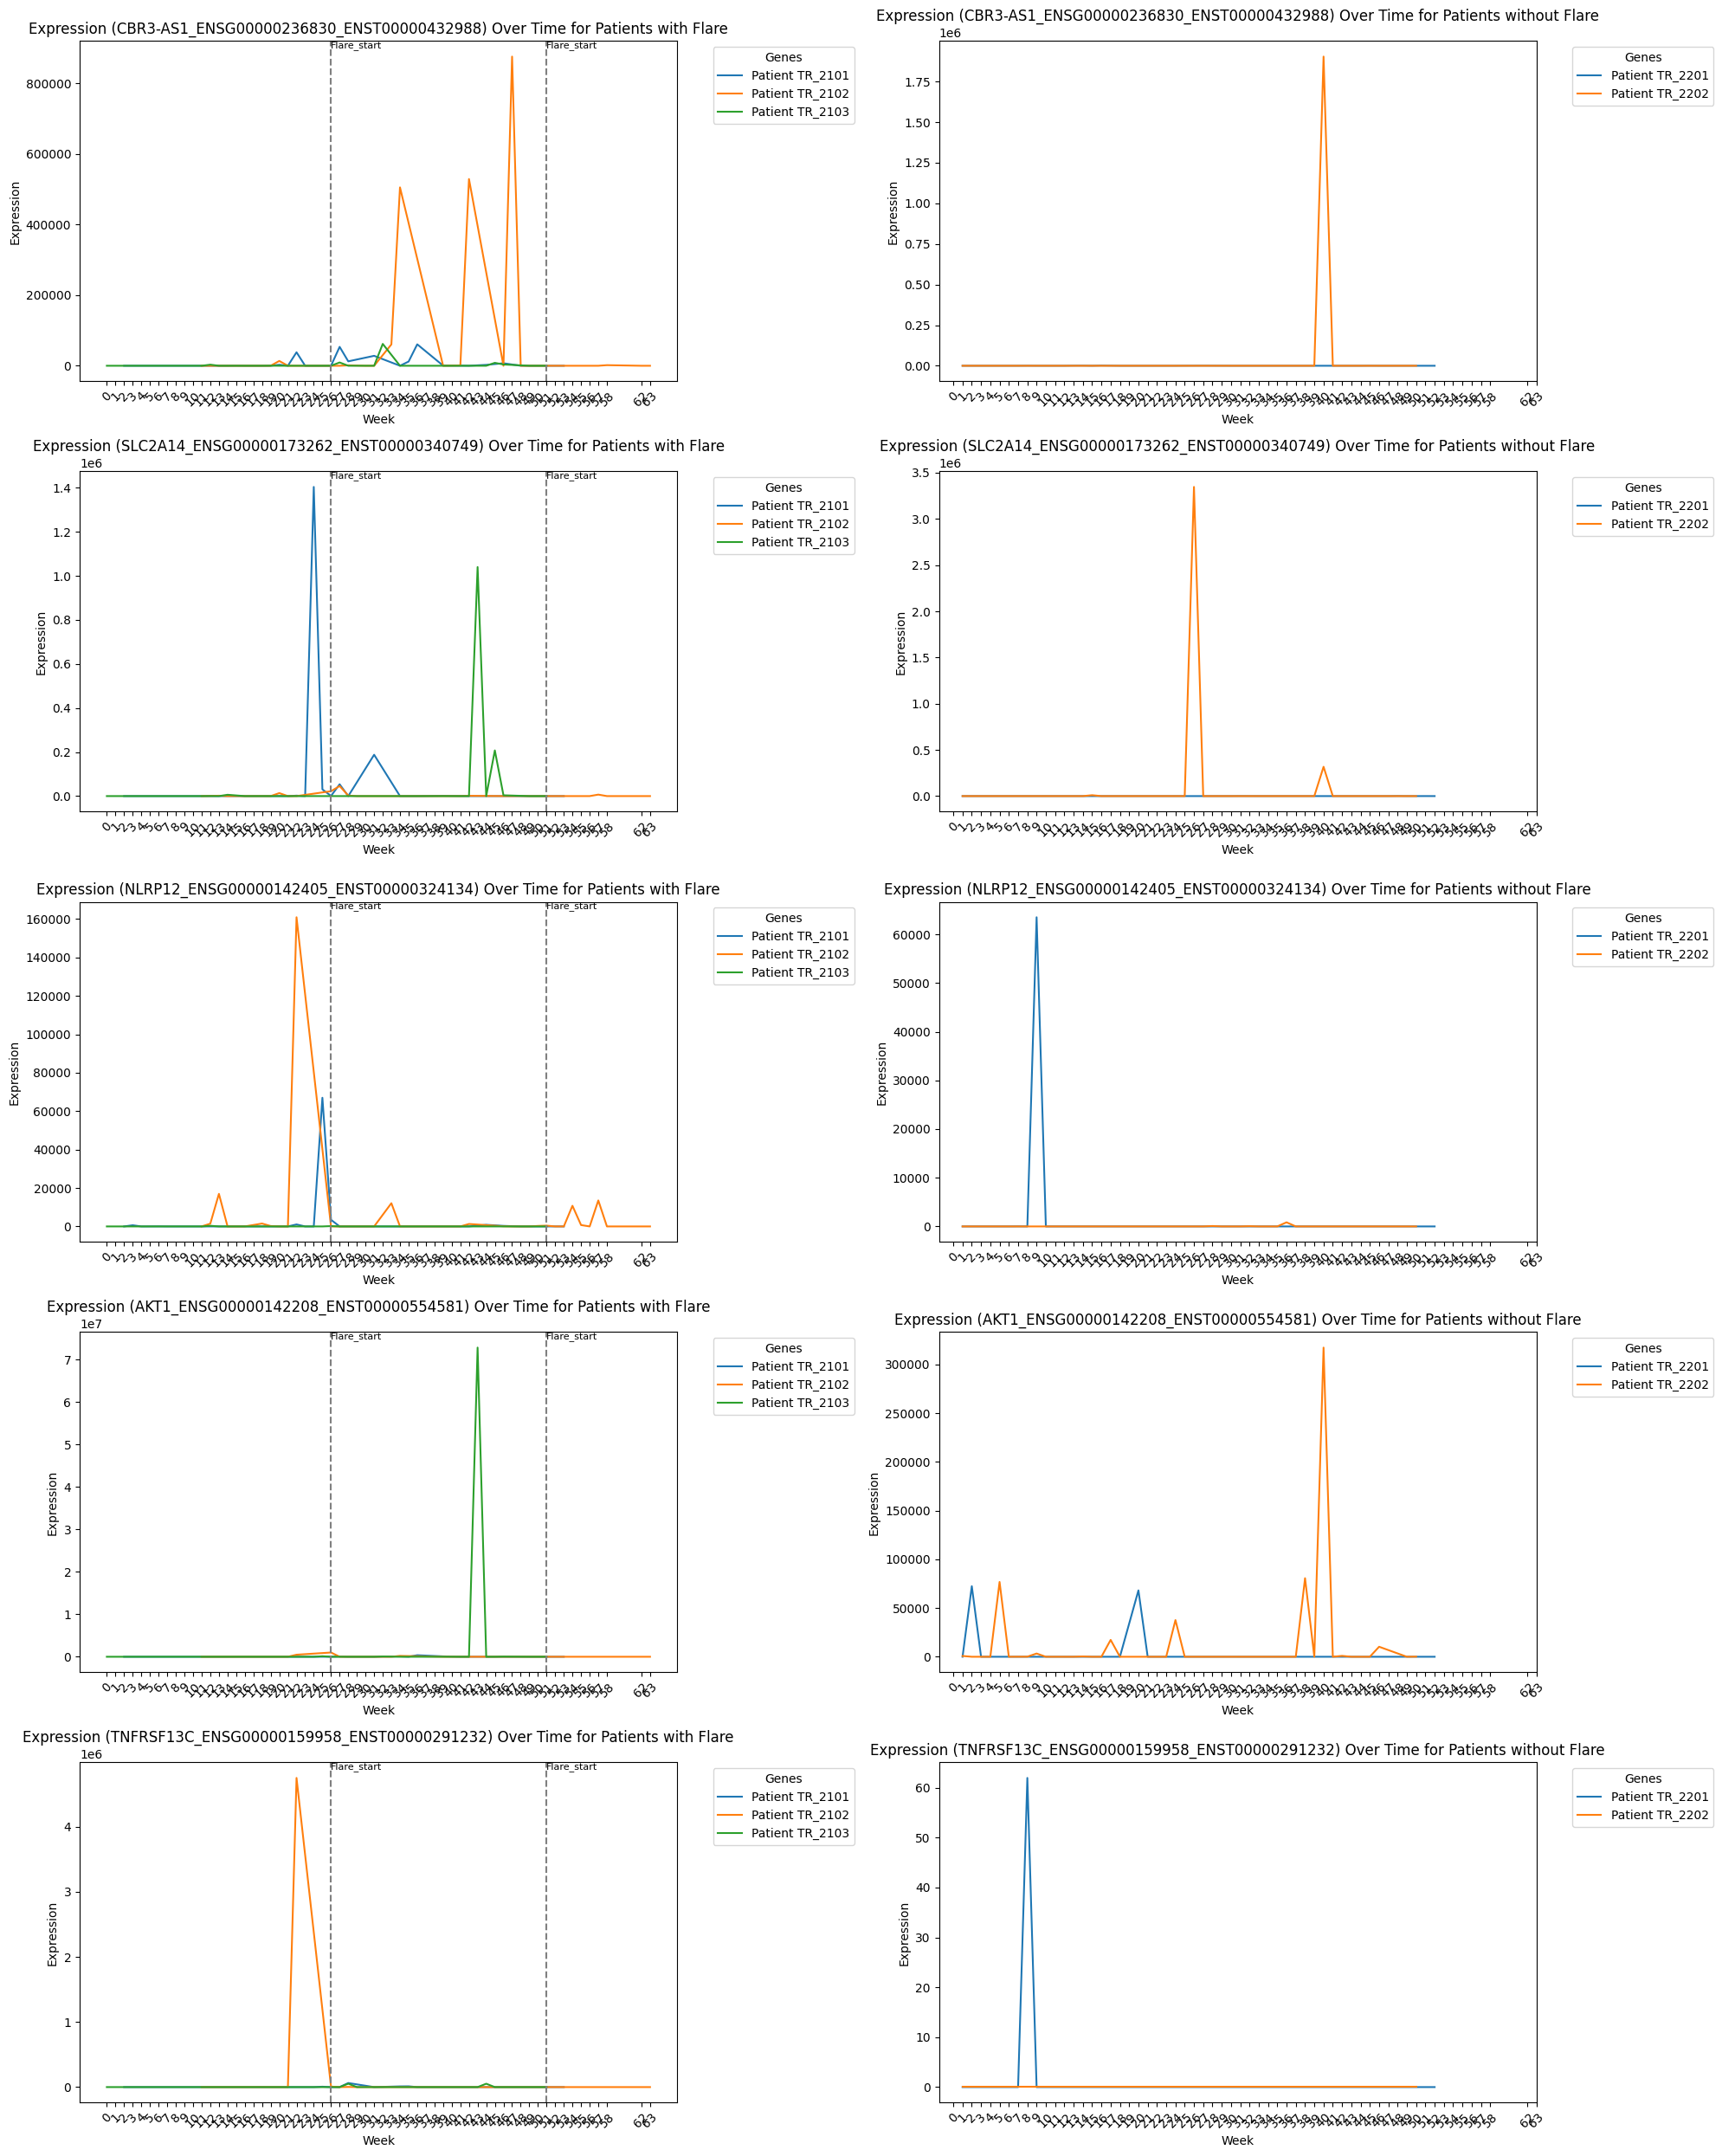

In [36]:
plot_species_abundance_over_time_2(gc, ['CBR3-AS1_ENSG00000236830_ENST00000432988','SLC2A14_ENSG00000173262_ENST00000340749','NLRP12_ENSG00000142405_ENST00000324134',
                                        'AKT1_ENSG00000142208_ENST00000554581','TNFRSF13C_ENSG00000159958_ENST00000291232'], 'Expression', 'Genes')

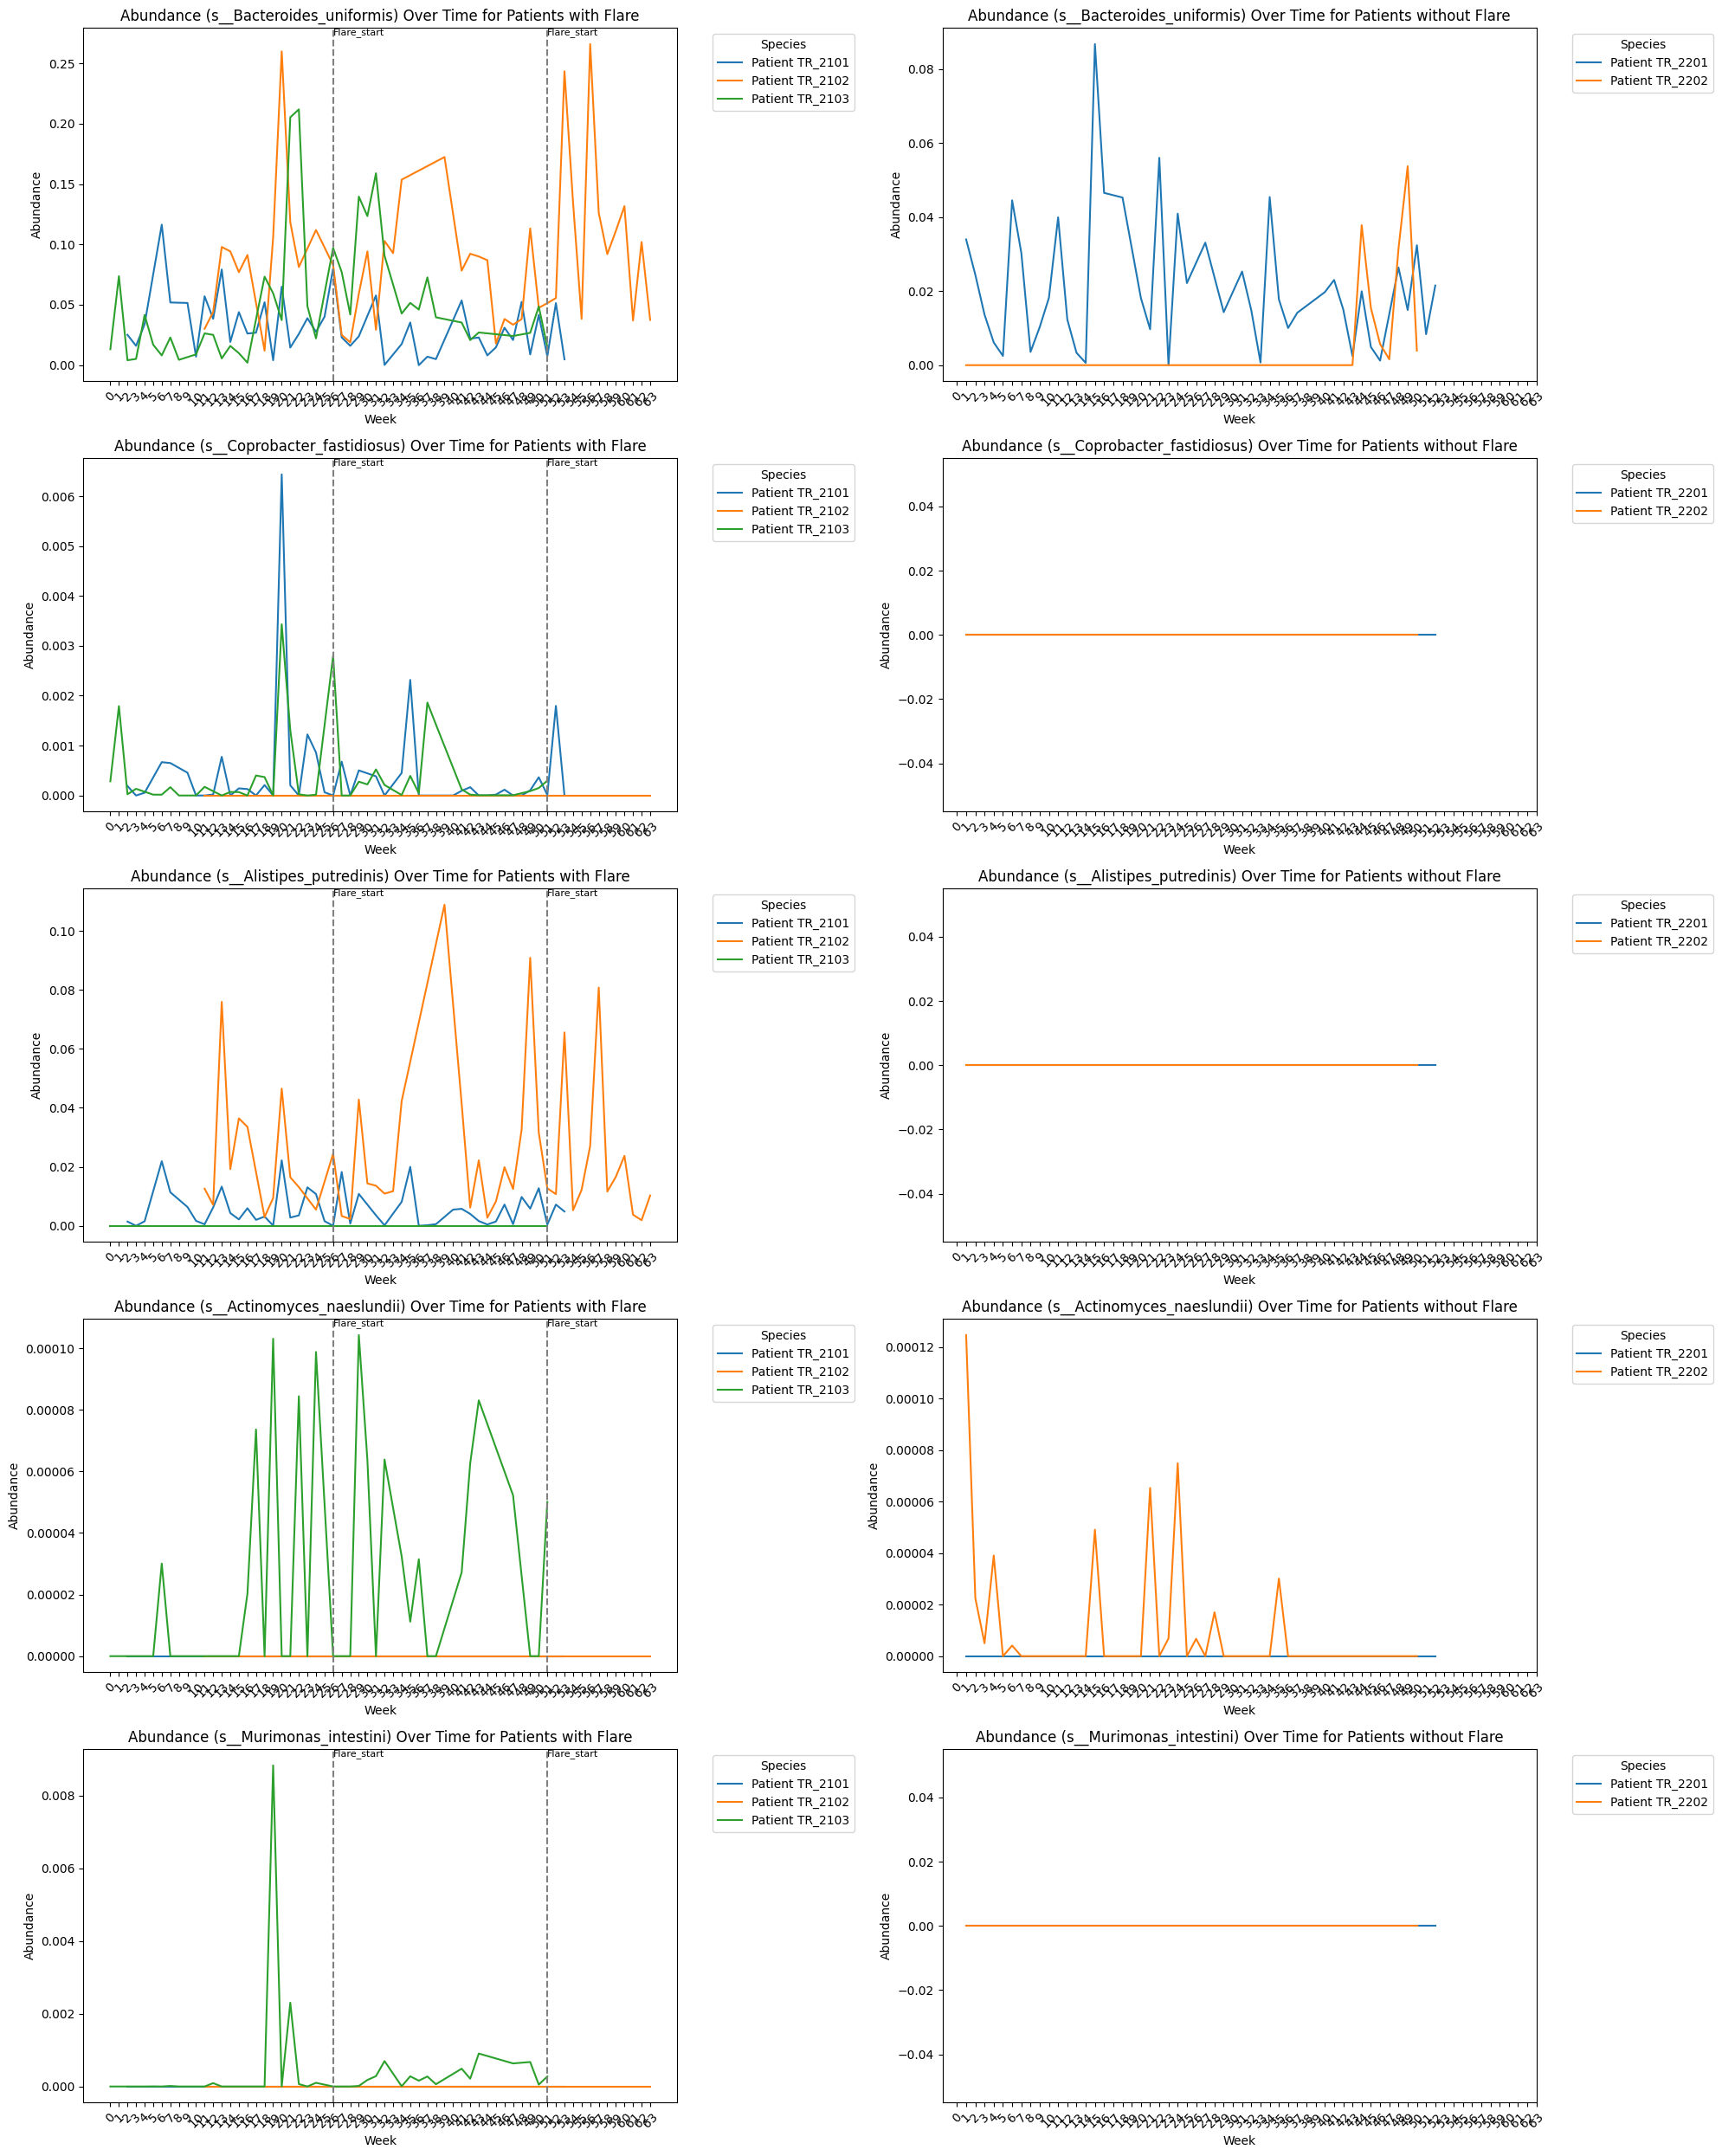

In [39]:
plot_species_abundance_over_time_2(mt, ['s__Bacteroides_uniformis','s__Coprobacter_fastidiosus','s__Alistipes_putredinis','s__Actinomyces_naeslundii','s__Murimonas_intestini'] , 'Abundance', 'Species')